Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [2]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [3]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

# fonction et classe filtering
from kalman_step_astolfi import kalman_step_complet
from EKF_astolfi import ExtendedKalmanFilterAstolfi

In [4]:
#pour le test utilise une image mais en vrai relier à la caméra et temps réel

cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()


#img_final= cv2.flip(img_final, 0)
img_final2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(img_final2)
img=vis.img_calibration(img_final2,corner_coord)
#cv2.imwrite('warpped.png', zzz)
plt.figure()
plt.imshow(img)
plt.show()



frame 0
frame 1
frame 2


KeyboardInterrupt: 

In [ ]:
#obstacle detection
polygons=vis.obstacle_detection(img)
#Start and goal detection
start=vis.detectCircle(img,'start')
goal=vis.detectCircle(img,'goal')

In [ ]:
#plot the visibility graph

#a voir si on le met dedans
margin = 35
path=glob.global_pathplanning(start,goal,polygons,margin)


# Control and navigation loop

In [7]:
#cap=cv2.VideoCapture(0)

frame 0
frame 1
frame 2
frame 3
frame 4


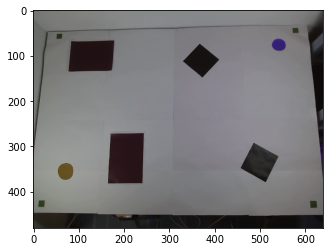

In [8]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

In [8]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#img= cv2.flip(img, 0)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

TypeError: img_calibration() missing 1 required positional argument: 'corner_coord'

In [4]:
def initialisation(pic):
    #obstacle detection
    polygons=vis.obstacle_detection(pic)
    #Start and goal detection
    start=vis.detectCircle(pic,'start')
    goal=vis.detectCircle(pic,'goal')
    init=[start,goal,polygons]
    return init



In [5]:
def printThymio(posThym, coordThym):
    coordThym.append((round(pos_thym[0]),round(pos_thym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,255,255), 2)

In [6]:
def printThymioKalm(posThym, coordThym):    #la couleur de la trace change
 #   print("print dans thymkalm")
 #   print(posThym[0])
 #   print("prochain round: ")
 #   print(round(posThym[0]))
    coordThym.append((round(posThym[0]),round(posThym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,0,255), 2)

In [7]:
#convertir frame to real => mm/s vitesse et position

#coefficients for the Astolfi controller (distances in millimeter)
r=22
l=48 
kp=25  #2 #>0
ka=50  #must be > kp
kb=-0.0001 #<0

#coeff_commtoreal=0,38

#astolfi return to iterate on the next goal from the path list

def astolfi(actual_pos, goal_pos, actual_angle, node):
    #déplacer les variables à l'extérieur dans control
    switch_next=0
    thresh_close2=10
    thresh_close1=75
    comm_sat_min=100
    comm_sat_max=250
    
    delta=np.subtract(goal_pos,actual_pos)
    pho=np.sqrt(np.sum(np.square(delta)))
    alpha=-actual_angle + np.arctan2(-delta[1],delta[0])
    beta=-actual_angle-alpha
    v=kp*pho
    if(pho<thresh_close1):
        v=comm_sat_min*r
    if(pho<thresh_close2):
        v=0
        switch_next=1      
    omega=ka*alpha+kb*beta
    #omega=0
    right_speed=(l*omega+v)/r
    left_speed=(v-l*omega)/r
    left_speed=int(left_speed)
    right_speed=int(right_speed)
    ctrl.set_motors(left_speed, right_speed, node)
    return switch_next

In [8]:
def printGlobalPath(path, img):
    lineThickness = 3
    for i in range(0,len(path)-1):
        cv2.line(final, (round(path[i][0]), round(path[i][1])),(round(path[i+1][0]), round(path[i+1][1])), (0,255,0), lineThickness)

In [9]:
print(init_pos)

NameError: name 'init_pos' is not defined

frame 0
frame 1
frame 2
frame 3
frame 4


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.49it/s]


Visibility graph points:  [[Point(388.30, 244.00), Point(390.68, 382.00), Point(532.32, 382.00), Point(534.70, 244.00)], [Point(114.15, 202.50), Point(108.86, 385.96), Point(266.84, 390.01), Point(272.14, 204.52)], [Point(346.14, -15.95), Point(236.20, 70.59), Point(329.86, 177.95), Point(439.80, 91.41)], [Point(-9.05, -23.27), Point(-4.93, 133.09), Point(183.00, 127.91), Point(183.00, -26.73)]] 

Shortest path distance: 581.9709006230225 

0    POLYGON ((388.304 244.000, 390.684 382.000, 53...
1    POLYGON ((114.152 202.499, 108.860 385.958, 26...
2    POLYGON ((346.141 -15.955, 236.202 70.593, 329...
3    POLYGON ((-9.047 -23.267, -4.933 133.087, 183....
0                              POINT (108.050 317.752)
1                              POINT (114.152 202.499)
2                              POINT (329.859 177.955)
3                               POINT (544.000 50.000)
dtype: geometry 

path  0    POINT (108.050 317.752)
1    POINT (114.152 202.499)
2    POINT (329.859 177.955)
3  

Vitesses droite / gauche -------------------
0.0
0.0
--------------------------------------------
temps entre samples:  0.24526667594909668
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
0.0
0.0
--------------------------------------------
temps entre samples:  0.1516246795654297
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
-0.0206364133718783
-0.020633035501473468
--------------------------------------------
temps entre samples:  0.14484596252441406
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
0.017998570578073927
18.476192135576294
--------------------------------------------
temps entre sample

elements:  2
elements:  2
Vitesses droite / gauche -------------------
34.269821322603036
40.789585432012906
--------------------------------------------
temps entre samples:  0.14602994918823242
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
33.193776265393936
39.9027106077662
--------------------------------------------
temps entre samples:  0.13407635688781738
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
32.54002324075008
38.87368811308257
--------------------------------------------
temps entre samples:  0.14608097076416016
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
32.6906903409796
37.7237

elements:  2
elements:  2
Vitesses droite / gauche -------------------
35.47881266787171
37.04060880220424
--------------------------------------------
temps entre samples:  0.13846659660339355
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
33.96096084803164
36.537988676976696
--------------------------------------------
temps entre samples:  0.14851975440979004
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
32.70754672472497
36.025796996233126
--------------------------------------------
temps entre samples:  0.13646960258483887
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
39.81861193762913
56.407

elements:  0
elements:  0
thymio indetectable
Vitesses droite / gauche -------------------
41.97037973532385
62.47273428622331
--------------------------------------------
temps entre samples:  0.14869070053100586
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 2.41958585e+02]
 [ 1.54284586e+02]
 [-4.13424987e-02]
 [ 4.19703797e+01]
 [ 6.24727343e+01]
 [ 5.22137074e+01]
 [ 1.04549751e+00]
 [-2.27803939e-01]]
vecteur d'etats apres update qd  thym cache:  [[ 2.41776383e+02]
 [ 1.54291908e+02]
 [-4.13466977e-02]
 [ 3.66983023e+01]
 [ 5.72115624e+01]
 [ 5.02021150e+01]
 [ 1.02544170e+00]
 [-2.27850224e-01]]
<class 'numpy.float64'>
elements:  0
elements:  0
thymio indetectable
Vitesses droite / gauche -------------------
36.698302309972746
57.211562374943554
--------------------------------------------
temps entre samples:  0.13325929641723633
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 2.48466282e+02]
 [ 1.54428558e+02]
 [-7.17098582e-02]

elements:  0
elements:  0
thymio indetectable
Vitesses droite / gauche -------------------
43.301367449619576
33.60344414121482
--------------------------------------------
temps entre samples:  0.14950346946716309
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 3.14433591e+02]
 [ 1.82024797e+02]
 [-3.06691868e-01]
 [ 4.33013674e+01]
 [ 3.36034441e+01]
 [ 3.30094608e+01]
 [ 2.30295959e+01]
 [ 1.07754703e-01]]
vecteur d'etats apres update qd  thym cache:  [[ 3.14383795e+02]
 [ 1.82004173e+02]
 [-3.02814770e-01]
 [ 4.68356767e+01]
 [ 2.69265485e+01]
 [ 3.24541610e+01]
 [ 2.27955733e+01]
 [ 1.51091739e-01]]
<class 'numpy.float64'>
failure in identifying corners
elements:  2
elements:  2
Vitesses droite / gauche -------------------
46.835676734926174
26.926548466383142
--------------------------------------------
temps entre samples:  0.15137672424316406
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elemen

elements:  2
elements:  2
Vitesses droite / gauche -------------------
36.37511737156441
38.96300321053638
--------------------------------------------
temps entre samples:  0.14485979080200195
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
failure in identifying corners
elements:  2
elements:  2
Vitesses droite / gauche -------------------
35.99661169616119
39.630602277078594
--------------------------------------------
temps entre samples:  0.1508774757385254
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
35.844132597250706
39.11207593597949
--------------------------------------------
temps entre samples:  0.13596558570861816
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche --------------

elements:  2
elements:  2
Vitesses droite / gauche -------------------
73.42866100055932
57.540524336634554
--------------------------------------------
temps entre samples:  0.13685917854309082
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  1
elements:  1
thymio indetectable
Vitesses droite / gauche -------------------
72.72380895141839
57.05509686441947
--------------------------------------------
temps entre samples:  0.14941191673278809
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 4.41724015e+02]
 [ 1.35583869e+02]
 [ 7.34497705e-01]
 [ 7.27238090e+01]
 [ 5.70550969e+01]
 [ 1.93839538e+01]
 [-7.71182563e+01]
 [ 1.74096801e-01]]
vecteur d'etats apres update qd  thym cache:  [[ 4.41667017e+02]
 [ 1.35620033e+02]
 [ 7.32551230e-01]
 [ 6.88147308e+01]
 [ 5.75604225e+01]
 [ 1.86060658e+01]
 [-7.64518630e+01]
 [ 1.44540184e-01]]
<class 'numpy.float64'>
elements:  1
elements:  1
thymio indete

failure in identifying corners
elements:  0
elements:  0
thymio indetectable
Vitesses droite / gauche -------------------
16.241404430844923
61.34673690002741
--------------------------------------------
temps entre samples:  0.13766908645629883
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 4.66397051e+02]
 [ 3.37913566e+01]
 [ 4.06841032e-01]
 [ 1.62414044e+01]
 [ 6.13467369e+01]
 [ 2.61579959e+01]
 [-3.40283069e+01]
 [-5.01170361e-01]]
vecteur d'etats apres update qd  thym cache:  [[ 4.66334708e+02]
 [ 3.38319897e+01]
 [ 4.06469738e-01]
 [ 1.34841049e+01]
 [ 5.95997174e+01]
 [ 2.53949086e+01]
 [-3.36311204e+01]
 [-5.05458057e-01]]
<class 'numpy.float64'>
elements:  0
elements:  0
thymio indetectable
Vitesses droite / gauche -------------------
13.484104854984695
59.59971741853249
--------------------------------------------
temps entre samples:  0.14497923851013184
obstacle devant camera
vecteur d'etats avant update qd  thym cache:  [[ 4.70016442e+02]
 [ 2.8

failure in identifying corners
elements:  2
elements:  2
Vitesses droite / gauche -------------------
46.802220700051464
25.750849689008508
--------------------------------------------
temps entre samples:  0.1355304718017578
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
45.533930563898295
26.781836524442323
--------------------------------------------
temps entre samples:  0.14777779579162598
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche -------------------
43.38900766303478
27.54719955411855
--------------------------------------------
temps entre samples:  0.13580679893493652
dans test de distance
bonne distance detectee, update
pas d'obstacle devant camera
<class 'numpy.float64'>
elements:  2
elements:  2
Vitesses droite / gauche ------------

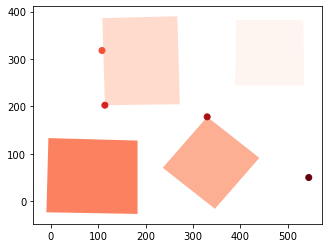

In [9]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()
#plt.figure()
#plt.imshow(frame)
#plt.show()

#time.sleep(1)
state=0
margin = 40
switch_next=0
path_iter=1
obst = [0,0,0]     # measurements from left, middle, right prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 3->2
obstThrL2 = 3000
obstThrH = 4000      # high obstacle threshold to switch state 2->3 
y = [0,0]          # powers given to motor wheels

#init des variables Kalman, et visu de la trace
KF = ExtendedKalmanFilterAstolfi()
KF.set_time_stamp(time.time())

sensor_package = []
kalman_pos = []

coordThym = []
coordKalm = []

while (cap.isOpened()):
    _, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #final=vis.img_calibration(img, corner_coord)
    #img= cv2.flip(img, 0)
    if(state==0):
        corner_coord=vis.find_corners(img)
        final=vis.img_calibration(img, corner_coord)
        init=initialisation(final)
        path=glob.global_pathplanning(init[0],init[1],init[2],margin)
        
        init_pos = [init[0][0], init[0][1]]
        
        KF.init_state_vector(init_pos[0],init_pos[1],0,0,0,0,0,0)   #xxx a rendre plus joli
        
        state=2
    #if state==1:
     #   time.sleep(6)
      #  print("time sleep over")
       # _, frame1 = cap.read()
        #plt.figure()
        #plt.imshow(frame1)
        #plt.show()
        #img1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        #state=2
    if (state==2):
        final=vis.img_calibration(img, corner_coord)
        #plt.figure()
        #plt.imshow(final1)
        #plt.show()
        pos_thym=vis.detectThymio(final)[0]
        angle_thym=vis.directionThymio(final)
        
        vit_roue_droite = ctrl.read_motors_speed(node,client)[1]#xxx droite ou gauche a verifier
        vit_roue_gauche = ctrl.read_motors_speed(node,client)[0]#droite ou gauche a verifier
        sensor_package = [pos_thym[0], pos_thym[1], angle_thym, vit_roue_droite, vit_roue_gauche]
 #       print(sensor_package)
        E = kalman_step_complet(sensor_package,KF)
        kalman_pos = [E[0], E[1]]
        kalman_pos = np.squeeze(np.asarray(kalman_pos))
 #       print("kalman pos: {}".format(kalman_pos))
        print(type(kalman_pos[0]))
        angle_kalman=E[2]
        angle_kalman = np.squeeze(np.asarray(angle_kalman[0]))
 #       print("kalman angle: {}".format(angle_kalman))
        
        #print(pos_thym)
        #print(angle_thym)
        #y = [50,50]
        #ctrl.set_motors(y[0],y[1],node)
        switch_next=astolfi(kalman_pos,path[path_iter],angle_kalman,node)
        if(switch_next==1):
            path_iter=path_iter+1
            print("path iter ",path_iter)
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                print("finish")
                state=4
                
        #local avoidance
        # get the proximity sensors values and obstacle update
        #prox_horizontal = ctrl.read_prox_sensors(node,client)
        #obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
        # update the state and speed motors values
        #state = local.update_state(state,obstThrL,obstThrH, obst)  
    if(state==3):
   #     print("local_nav")
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
        state = local.update_state(state,obstThrL,obstThrH, obst)
  #      print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
   #     print("y ",y)
        ctrl.set_motors(y[0],y[1],node)
    if state==4:
        break
    vis.printGlobalPath(path, final)
   # printThymio(pos_thym, coordThym)
 #   print(kalman_pos)
 #   print(coordKalm)
    printThymioKalm(kalman_pos,coordKalm)
    cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
#cv2.destroyAllWindows()

In [ ]:
type(kalman_pos)
round(-10.939384)
print(kalman_pos)
print(round(kalman_pos[0]))
round(-294992929.8484)

In [ ]:
print("kalman pos: ",kalman_pos)
print("kalman pos: ", np.asarray(kalman_pos[0][0]))
print("kalman pos: ", np.squeeze(np.asarray(kalman_pos))[0])

In [11]:
ctrl.stopmotors(node)


In [5]:
test=[[None,None],[None,None]]
if bool(not test[0][0]):
    print("zeub")

zeub


In [ ]:
def detectThymio(imgRGB):
    pts=[]
    #p1 is the big circle and p2 the little
    p1=[]
    p2=[]
    lower=np.array([10,30,30])
    upper=np.array([40,255,255])
    nb_iterations=1
    img_hsv = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lower, upper)
    img_hsv = cv2.blur(img_hsv,(7,7))
    mask = cv2.erode(mask, None, iterations = nb_iterations)
    mask = cv2.dilate(mask, None, iterations = nb_iterations)
    elements,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(elements))
    if len(elements) > 0:
        #sorting the detected contours by descending area size
        elements.sort(key=cv2.contourArea, reverse=True)
        #finding big circle
        c=elements[0]
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        #finding little circle
        c2=elements[1]
        ((x2,y2),rayon2) = cv2.minEnclosingCircle(c2)
        p1=[x,y]
        p2=[x2,y2]
        pts=[p1,p2]
    return pts

#print(detectThymio(final))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(frame)
final=vis.img_calibration(frame, corner_coord)
print(detectThymio(final)[0])

In [19]:
print(init)

[[112.5, 369.5], [0, 0], [[(253, 285), (298, 291), (283, 374), (238, 368)], [(180, 161), (186, 213), (124, 224), (120, 171)], [(382, 139), (439, 144), (436, 199), (377, 193)]]]


In [7]:
# Navigation initialisation
checkp=1           # goal checkpoint
actual_angle=0     # angle to xy axis
y = [0,0]          # powers given to motor wheels

# FSM initialisation
state = 0          # States FSM 0=global nav, 1=local nav
obst = [0,0,0]     # measurements from left, middle, right prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 1->0
obstThrL2 = 3000
obstThrH = 4000      # high obstacle threshold to switch state 0->1  

while True:
    
    # get the proximity sensors values and obstacle update
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = local.update_state(state,obstThrL,obstThrH, obst)
    y = ctrl.read_motors_speed(node,client)
    
    print("state", state)

    if state == 0:
        
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        y = [50,50]
        ctrl.set_motors(y[0],y[1],node)

    elif state == 1:
        print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
        print("y ",y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

NameError: name 'node' is not defined

In [10]:
ctrl.stopmotors(node)